# Milestone 2


## Perkenalan



Program ini dibuat untuk menganalisis kumpulan data pemesanan penerbangan yang diperoleh dari situs Ease My Trip dan melakukan berbagai uji hipotesis statistik untuk mendapatkan informasi yang bermakna. Model KNeighborsRegressor, SVR, DecisionTreeRegressor, RandomForestRegressor dan GradientBoostingRegressor akan digunakan untuk melatih kumpulan data dan memprediksi harga tiket pesawat. Ease My Trip adalah platform internet untuk memesan tiket penerbangan, dan karenanya merupakan platform yang digunakan calon penumpang untuk membeli tiket. Hasil dari analisa ini akan sangat bermanfaat bagi penumpang.

## Import Libraries

In [485]:
import pandas as pd
import numpy as np
from scipy import stats

# Untuk kebutuhan visual
import matplotlib.pyplot as plt
import seaborn as sns

# Untuk Download data set
import opendatasets as od

# Untuk kebuthan model evaluasi
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

# Untuk kebutuhan split data
from sklearn.model_selection import train_test_split

# Untuk kebutuhan cek VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Untuk kebutuhan scale dan encod data
from sklearn.preprocessing import StandardScaler , OneHotEncoder, OrdinalEncoder ,PolynomialFeatures

# Untuk kebutuhan handling outlier
from feature_engine.outliers import Winsorizer

# Untuk saving model, scaler dan encoder
import pickle

from sklearn.neighbors import KNeighborsRegressor

from sklearn.svm import SVR

from sklearn.tree import DecisionTreeRegressor

from sklearn.ensemble import RandomForestRegressor

from sklearn.ensemble import GradientBoostingRegressor

from sklearn.model_selection import StratifiedKFold

from sklearn.model_selection import cross_val_score

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.model_selection import RandomizedSearchCV

## Data Loading

### Download Data

In [486]:
data = od.download('https://www.kaggle.com/datasets/shubhambathwal/flight-price-prediction?select=Clean_Dataset.csv')

Skipping, found downloaded files in "./flight-price-prediction" (use force=True to force download)


### Read Data

In [487]:
df = pd.read_csv('/Users/saepulhilal/Hacktiv8/PHASE 1/p1-ftds010-hck-m2-saepulhilal/flight-price-prediction/Clean_Dataset.csv')

### Deskripsi Kolom

| Kolom | Deskripsi |
| --- | --- |
|Airline | Nama perusahaan penerbangan|
|Flight|Informasi mengenai kode penerbangan pesawat|
|Source City | Kota asal penerbangan|
|Departure Time |Informasi tentang waktu keberangkatan|
|Stops |Jumlah perhentian antara kota sumber dan kota tujuan|
|Arrival Time |Informasi tentang waktu kedatangan|
|Destination City | Kota dimana penerbangan akan mendarat|
|Class |Bisnis dan Ekonomi|
|Duration |Jumlah keseluruhan waktu yang diperlukan untuk melakukan perjalanan antar kota dalam hitungan jam	|
|Days Left |Ini adalah karakteristik turunan yang dihitung dengan mengurangkan tanggal perjalanan dengan tanggal pemesanan|
|Price |Informasi harga tiket|

### Menampilkan 5 Baris Pertama dan Terakhir

In [488]:
df.head()

,Unnamed: 0,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,0,SpiceJet,SG-8709,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1,5953
1,1,SpiceJet,SG-8157,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.33,1,5953
2,2,AirAsia,I5-764,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1,5956
3,3,Vistara,UK-995,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.25,1,5955
4,4,Vistara,UK-963,Delhi,Morning,zero,Morning,Mumbai,Economy,2.33,1,5955


In [489]:
df.tail()

,Unnamed: 0,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
300148,300148,Vistara,UK-822,Chennai,Morning,one,Evening,Hyderabad,Business,10.08,49,69265
300149,300149,Vistara,UK-826,Chennai,Afternoon,one,Night,Hyderabad,Business,10.42,49,77105
300150,300150,Vistara,UK-832,Chennai,Early_Morning,one,Night,Hyderabad,Business,13.83,49,79099
300151,300151,Vistara,UK-828,Chennai,Early_Morning,one,Evening,Hyderabad,Business,10.00,49,81585
300152,300152,Vistara,UK-822,Chennai,Morning,one,Evening,Hyderabad,Business,10.08,49,81585


### Delete kolom yang tidak terpakai

Ada 1 kolom yang tidak memiliki manfaat. Yaitu kolom Unamed: 0, kolom tersebut berisi angka yang sama seperti index

In [490]:
df = df.drop('Unnamed: 0',axis=1)

### Mengganti nama kolom

Kolom dengan nama class akan diganti untuk mempermudah proses analisa.

In [491]:
df = df.rename(columns={"class":"type"})

### Shape of Data

In [492]:
df.shape

(300153, 11)

Data set ini memiliki 300.153 baris data dan 11 kolom. Untuk baris data pada data ini menurut peneliti terbilang banyak. Maka dari itu peneliti akan mengambil 50.000 sampel datanya saja. hal ini dilakukan untuk mempercepat dari proses komputasi

### Data Sampling

In [493]:
df_sampling = df.sample(50000,random_state=42)
df_sampling.shape

(50000, 11)

### General Information

In [495]:
df_sampling.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50000 entries, 27131 to 15601
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   airline           50000 non-null  object 
 1   flight            50000 non-null  object 
 2   source_city       50000 non-null  object 
 3   departure_time    50000 non-null  object 
 4   stops             50000 non-null  object 
 5   arrival_time      50000 non-null  object 
 6   destination_city  50000 non-null  object 
 7   type              50000 non-null  object 
 8   duration          50000 non-null  float64
 9   days_left         50000 non-null  int64  
 10  price             50000 non-null  int64  
dtypes: float64(1), int64(2), object(8)
memory usage: 4.6+ MB


Data set ini memiliki 11 kolom yang terdiri dari 1 float, 2 int dan 8 object

### Check Missing Values

In [496]:
df_sampling.isnull().sum()

airline             0
flight              0
source_city         0
departure_time      0
stops               0
arrival_time        0
destination_city    0
type                0
duration            0
days_left           0
price               0
dtype: int64

Data set ini tidak memilki missing values

### Check Duplicated

In [497]:
df_sampling.duplicated().sum()

0

Tidak terdapat data duplicated pada data set ini

##  EDA

### Harga Tiket Berdasarkan Maskapai

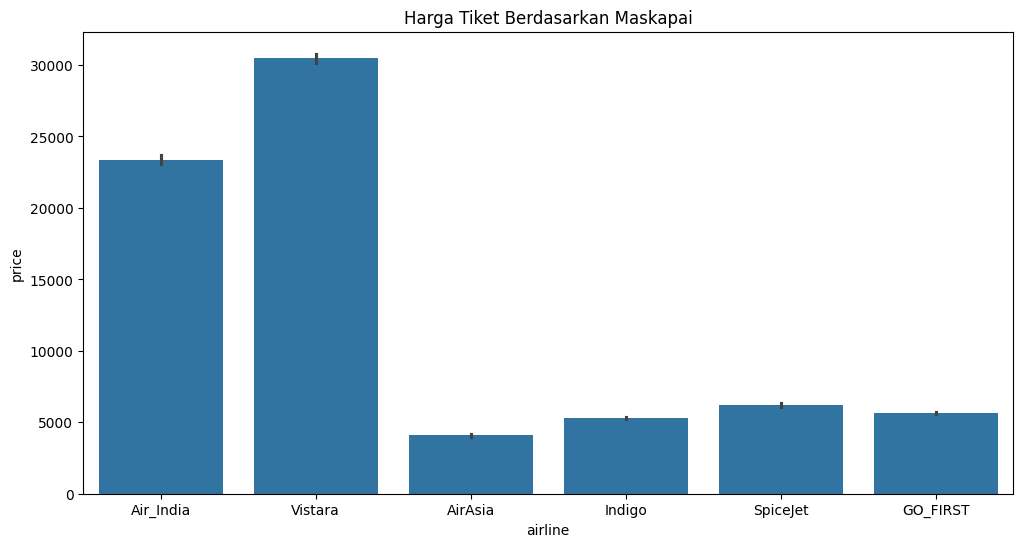

In [498]:
plt.figure(figsize=(12, 6))
sns.barplot(x='airline', y='price', data=df_sampling)
plt.title('Harga Tiket Berdasarkan Maskapai')
plt.show()

Insight :

Berdasarkan visual diatas, diketahui bahwa maskapai vistara merupakan maskapai dengan harga tiket termahal disusul oleh maskapai Air India dan maskapai AirAsia adalah yang termurah

### Perubahan Harga Tiket Berdasarkan Waktu Keberangkatan dan Kedatangan

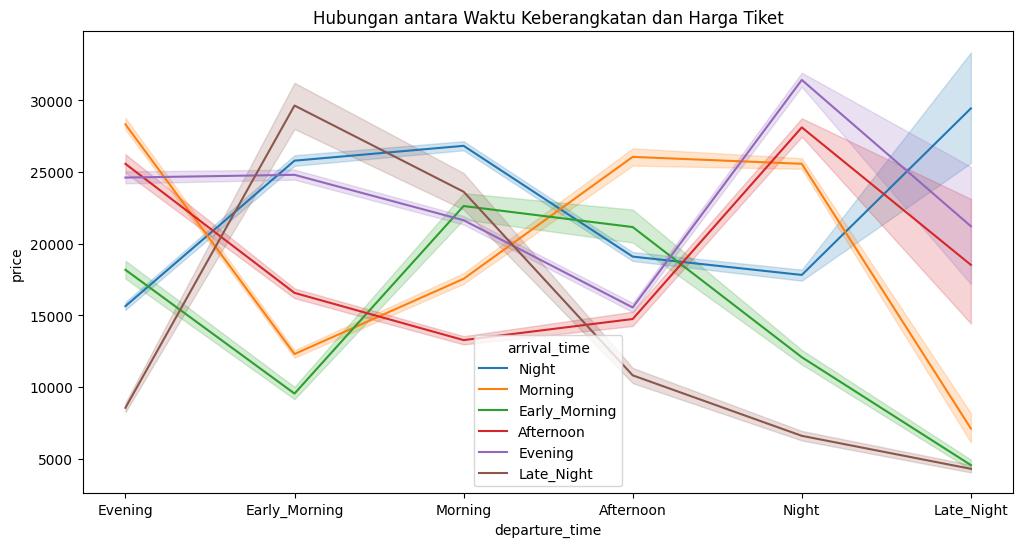

In [499]:
# Scatter plot untuk melihat hubungan antara waktu keberangkatan dan harga
plt.figure(figsize=(12, 6))
sns.lineplot(x='departure_time', y='price', data=df, hue='arrival_time')
plt.title('Hubungan antara Waktu Keberangkatan dan Harga Tiket')
plt.show()



Insight :

Dapat diketahui bahwa harga tiket berdasarkan waktu keberangkatan dan waktu kedatangan sangat berfariasi


### Pengaruh Harga Tiket dengan Jumlah Hari Sebelum Keberangkatan

In [500]:
# Membuat variable yang berisi groupby dari source city, destination city dan days left
gby1 = df.groupby(['source_city', 'destination_city', 'days_left'])['price'].mean()
gby1

source_city  destination_city  days_left
Bangalore    Chennai           1            22647.710526
                               2            32438.043956
                               3            30463.322917
                               4            25613.474227
                               5            24440.059322
                                                ...     
Mumbai       Kolkata           45           20009.839552
                               46           21356.389961
                               47           20899.023715
                               48           20550.008032
                               49           20710.546875
Name: price, Length: 1470, dtype: float64

In [501]:
gby1 = gby1.reset_index()

In [502]:
gby1['combined_col'] = gby1['source_city'] + '_' + gby1['destination_city']

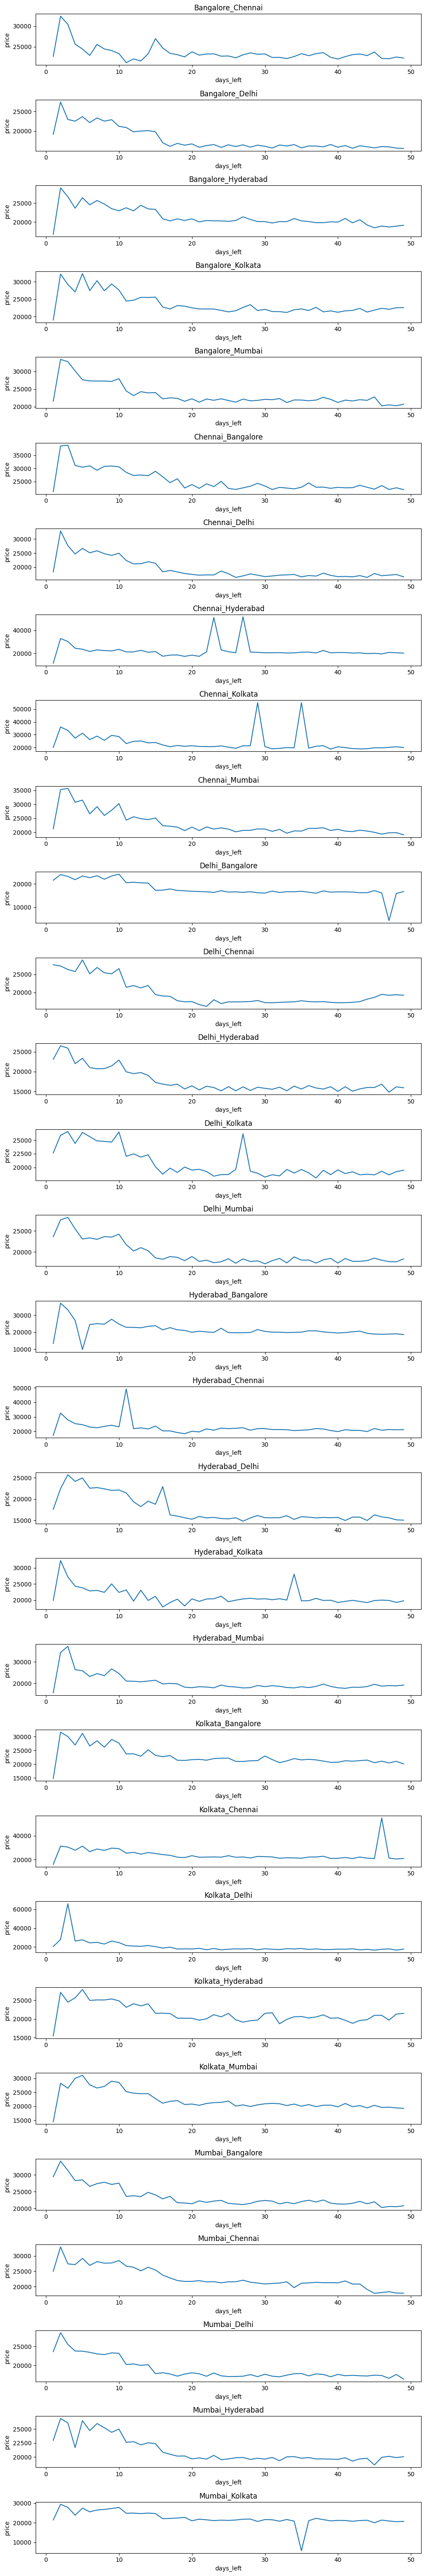

In [503]:
# Membuat line plot
plt.figure(figsize=(10,60))
for indx, val in enumerate(gby1.combined_col.unique()):
    plt.subplot(30,1,indx+1)
    temp_df = gby1.loc[gby1['combined_col'] == val]
    plt.plot(temp_df['days_left'], temp_df['price'])
    plt.title(val)
    plt.xlabel('days_left')
    plt.ylabel('price')

plt.tight_layout()

Insight :

Secara keselurhan rata-rata dari harga tiket ketika mendekati hari keberangkatan memiliki visual yang cenderung ke arah up trend. Untuk lebih jelas dapat dilihat langsung berdasarkan kota asal dan kota tujuan yang ingin dipilih

### Perubahan Harga Tiket Berdasarkan Kota Keberengkatan dan Tujuan

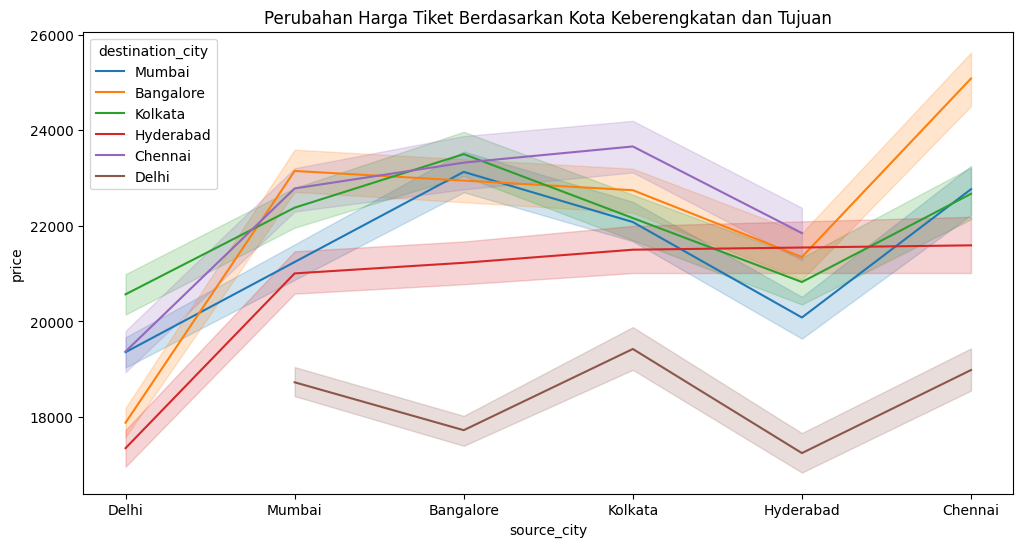

In [504]:
plt.figure(figsize=(12, 6))
sns.lineplot(x='source_city', y='price', hue='destination_city', data=df)
plt.title('Perubahan Harga Tiket Berdasarkan Kota Keberengkatan dan Tujuan')
plt.show()

Insight :

Bisa dilihat dari visual diatas bahwa harganya begitu variatif. Contoh penerbangan dari kota Kolkata ke Delhi memiliki harga di sekitar 19.000 namun penerbangan dari kota Delhi ke Kolkata berkisar pada 21.000 sehingga memiliki selisih sekitar 1.100

### Perbedaan Harga Tiket antara Kelas Ekonomi dan Bisnis

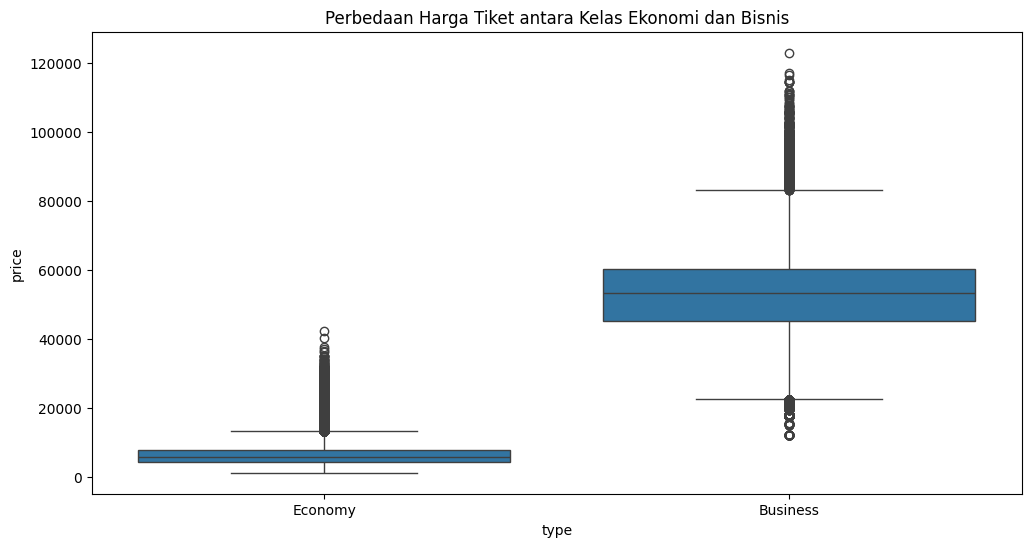

In [505]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='type', y='price', data=df)
plt.title('Perbedaan Harga Tiket antara Kelas Ekonomi dan Bisnis')
plt.show()

In [506]:
ekonomi = df[df['type'] == 'Economy']
bisnis = df[df['type'] == 'Business']

print(f'Haraga ekonomi dari {ekonomi["price"].min()} sampai {ekonomi["price"].max()}')
print(f'Haraga bisnis dari {bisnis["price"].min()} sampai {bisnis["price"].max()}')

Haraga ekonomi dari 1105 sampai 42349
Haraga bisnis dari 12000 sampai 123071


Insight :
Dapat dilihat perbedaan dari harga tiket pesawat berdasarkan kelasnya untuk ekonomi memilki range harga dari 1.105 hingga 42.349 sedangkan untuk kelas bisnis dari 12.000 hingga 123.071

##  Feature Engineering

### Split Data

Pada tahap ini akan dilakukan split data untuk memisahkan data train dan data test. Untuk data test akan mengambil 20% dari data frame dfNotNa dan sisanya yaitu 80% akan dijadikan data train dengan random state 42.

In [507]:
# Split data
df_copy = df_sampling.copy()
X = df_copy.drop(['price'], axis=1)
y = df_copy['price']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

print(f"Shape data train : {X_train.shape}")
print(f"Shape data test : {X_test.shape}")

Shape data train : (40000, 10)
Shape data test : (10000, 10)


### Handling Outliers

Handling outliers dilakukan sebelum mencari hubungan korelasi antara fitur dengan target. hal ini disebabkan karena outlier dapat mempengaruhi nilai tersebut

In [508]:
# Mencari kolom yang normal dan skew
xtrain_num = X_train[['duration','days_left']]
xtrain_cat = X_train[['airline', 'flight', 'source_city', 'departure_time', 'stops','arrival_time', 'destination_city', 'type']]

skewnes = []
normal = []
for i in xtrain_num :
    # print(i)
    skew = xtrain_num[i].skew()
    if skew < -0.5 or skew > 0.5:
        skewnes.append(i)
    else:
        normal.append(i)

print(f"kolom yang skew : {skewnes}")
print(f"kolom yang normal : {normal}")

kolom yang skew : ['duration']
kolom yang normal : ['days_left']


Text(0.5, 1.0, 'Visual Before Handling Outlier')

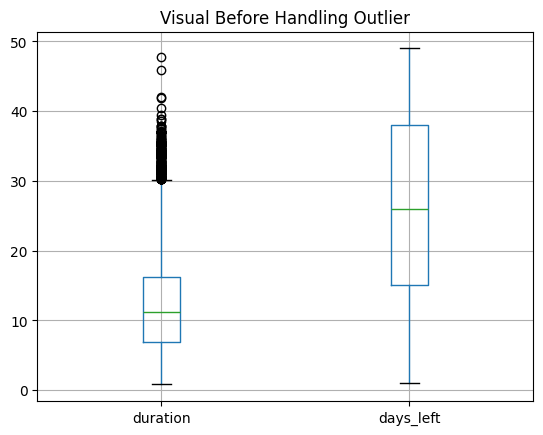

In [509]:
X_train.boxplot()
plt.title("Visual Before Handling Outlier")

Handling outlier akan dilakukan menggunakan winsorizer dengan metode iqr dan fold 1.5 hal ini dilakukan karena kolom duration memiliki distribusi yang tidak normal. Dan untuk kolom days_left akan dilakukan dengan metode gaussian karena kolom tersebut normal

In [510]:
# Handling outlier dengan iqr
wzi = Winsorizer(capping_method='iqr', tail='both', fold=1.5, variables=['duration'] )
X_train = wzi.fit_transform(X_train)

In [511]:
# Handling outlier dengan gaussian
wzg = Winsorizer(capping_method='gaussian', tail='both', fold=1.5, variables=['days_left'] )
X_train = wzg.fit_transform(X_train)

Text(0.5, 1.0, 'Visual After Handling Outlier')

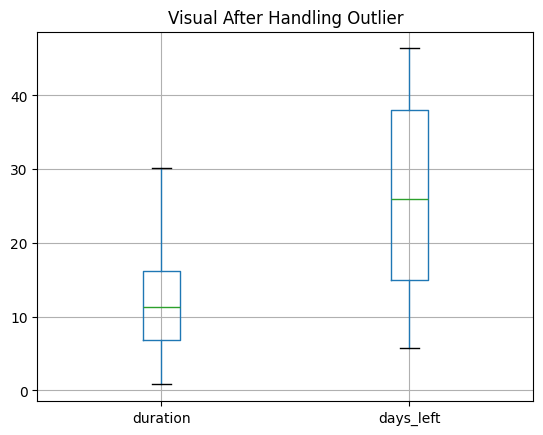

In [512]:
X_train.boxplot()
plt.title("Visual After Handling Outlier")

### Mencari Hubungan Korelasi dengan Target

#### Uji Pearson

dilakukan untuk kolom bertipedata int dan float

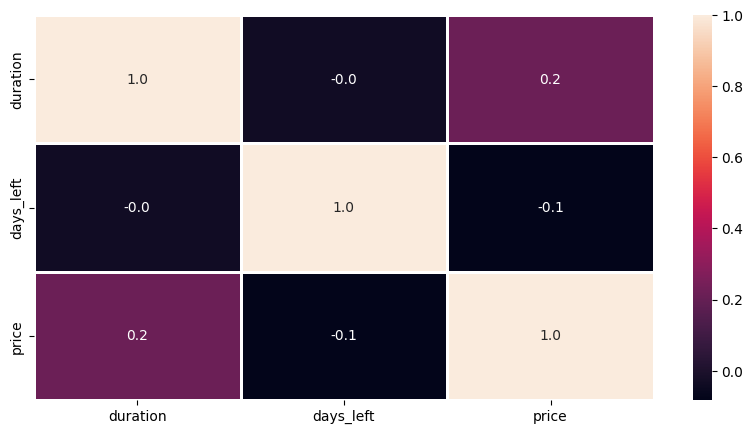

In [513]:
heatmap = X_train[['duration', 'days_left']].copy()
heatmap['price'] = y_train

# Uji Pearson's
plt.figure(figsize=(10,5))
sns.heatmap(heatmap.corr(method='pearson'),annot=True,fmt=".1f",linewidths="1");

#### Uji Kendall

Dilakukan untuk kolom bertipe data object

In [514]:
# Uji Kendall
for i in xtrain_cat:
    corr_r, pval_p = stats.kendalltau(X_train[i], y_train)
    print(f"{i} dengan Price")
    print(f"Nilai korelasi :{corr_r}")
    if pval_p < 0.05:
        print(f"P-value :{pval_p} ---> ada korelasi denga price")
    else:
        print(f"P-value :{pval_p}")

    print('---'*10)

    


airline dengan Price
Nilai korelasi :0.21374017624679045
P-value :0.0 ---> ada korelasi denga price
------------------------------
flight dengan Price
Nilai korelasi :0.21634959954772973
P-value :0.0 ---> ada korelasi denga price
------------------------------
source_city dengan Price
Nilai korelasi :0.015428904069400293
P-value :1.9118828474520038e-05 ---> ada korelasi denga price
------------------------------
departure_time dengan Price
Nilai korelasi :0.043373411274728504
P-value :1.8328002629786634e-32 ---> ada korelasi denga price
------------------------------
stops dengan Price
Nilai korelasi :-0.18950813370928432
P-value :0.0 ---> ada korelasi denga price
------------------------------
arrival_time dengan Price
Nilai korelasi :0.03022288912181789
P-value :2.0881970235531678e-16 ---> ada korelasi denga price
------------------------------
destination_city dengan Price
Nilai korelasi :0.01004330953685534
P-value :0.005354574239614141 ---> ada korelasi denga price
---------------

Setelah melakukan uji Pearson dan Kendall, mendapatkan hasil bahwa semua kolom yang ada pada data set ini memiliki nilai korelasi > 0,1 dan < -0,1. maka semua kolom akan dijadikan sebagai calon feature. semua kolom itu adalah : 'duration','days_left', 'airline', 'flight', 'source_city', 'departure_time', 'stops','arrival_time', 'destination_city', 'class'

### Cardinality

Pengujian ini dilakukan pada fitur yang memiliki tipe data object. Tujuan dari pengujian ini adalah untuk melihar apakah ada fitur yang memiliki nilai high cardinality

In [515]:
# Cek Cardinality
for i in xtrain_cat:
    print("Jumlah kategori pada variable ",i,": {}".format(len(X_train[i].unique())))


Jumlah kategori pada variable  airline : 6
Jumlah kategori pada variable  flight : 1403
Jumlah kategori pada variable  source_city : 6
Jumlah kategori pada variable  departure_time : 6
Jumlah kategori pada variable  stops : 3
Jumlah kategori pada variable  arrival_time : 6
Jumlah kategori pada variable  destination_city : 6
Jumlah kategori pada variable  type : 2


Hasil dari pengujian adalah kolom flight memiliki nilai high cardinality. Maka peneliti akan mencoba untuk menghandlingnya

In [516]:
X_train.flight.unique()

array(['AI-773', 'UK-832', 'AI-804', ..., 'SG-9911', '6E-963', '6E-6572'],
      dtype=object)

In [517]:
X_train.airline.unique()

array(['Air_India', 'Vistara', 'SpiceJet', 'Indigo', 'AirAsia',
       'GO_FIRST'], dtype=object)

Peneliti telah mecoba untuk melakukan handling pada kolom flight, Namun peneliti memiliki kendala keterbatasan pengetahuan dalam kode maskapai ini, sehingga peneliti mengambil keputusan untuk menghapus kolom flight

In [518]:
X_train = X_train.drop('flight',axis=1)
X_test = X_test.drop('flight',axis=1)

### Multicolinearity

Test multicolineatity bertujuan untuk memastikan bahwa hubungan antar fitur tidak saling mempengaruhi. Maka untuk mengetahui nilai dari hubungan setiap fitur akan dilakukan pengujian menggunakan VIF dengan treshold 10. Aritnya jika ada nilai yang melebihi 10 kolom tersebut akan dianggap dipengaruhi oleh fitur lain dan kolom tersebut akan dihapus. Sebelum melakukan Uji VIF akan dilakukan encoding terlebih dahulu dengan menggunakan OrdinalEncoder()

#### Encod Ordinal

In [519]:
oe=OrdinalEncoder()

X_train_oe=oe.fit_transform(X_train[['airline', 'source_city', 'departure_time', 'stops','arrival_time', 'destination_city', 'type']])

X_train_name=X_train[['airline', 'source_city', 'departure_time', 'stops','arrival_time', 'destination_city', 'type']]

X_train_oe=pd.DataFrame(X_train_oe,columns=oe.get_feature_names_out(X_train_name.columns))

X1 = X_train[['duration','days_left']]

X_train_multi = np.concatenate([X_train_oe,X1],axis=1)

X_train_multi = pd.DataFrame(X_train_multi,columns=X_train.columns)

#### Uji VIF

In [520]:
# Fungsi untuk cek nilai multicolinearity
def calc_vif(X):

    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return(vif)

In [521]:
calc_vif(X_train_multi)

,variables,VIF
0,airline,3.383175
1,source_city,2.929239
2,departure_time,2.785898
3,stops,1.424655
4,arrival_time,3.669326
5,destination_city,2.916014
6,type,2.861346
7,duration,4.189942
8,days_left,4.172013


setelah melakukan pengujian tidak terdapat kolom yang memiliki nilai diatas 10. Maka 9 kolom diatas akan dijadikan sebagai fitur

## Model Definition and Training

### KNeighborsRegressor

In [530]:
knn = KNeighborsRegressor()

KNeighborsRegressor adalah algoritma untuk memprediksi nilai kontinu dengan mempertimbangkan tetangga terdekat. Pengaturannya melibatkan n_neighbors dan weights. Metrik umumnya adalah Mean Squared Error (MSE). Model ini sensitif terhadap variasi kecil dalam data dan membutuhkan komputasi intensif, terutama pada dataset besar. Pemilihan model dan pengaturan yang tepat penting untuk hasil yang baik.

### SVR

In [531]:
svr = SVR()

Support Vector Regression (SVR) digunakan dalam machine learning untuk memodelkan hubungan antara variabel dependen dan independen, khususnya ketika terdapat pola nonlinier dalam data. Keunggulan SVR melibatkan kemampuannya menangani data nonlinier, ketahanannya terhadap outlier, dan kontrol yang diberikan terhadap kompleksitas model.

Beberapa hyperparameter yang relevan untuk disesuaikan dalam SVR mencakup pilihan jenis kernel (linear, polinomial, RBF), parameter C untuk mengontrol trade-off antara kesalahan pelatihan dan kompleksitas model, parameter epsilon yang mengatur lebar koridor, dan gamma khusus untuk kernel RBF.

Metrics umum yang digunakan untuk mengevaluasi performa SVR termasuk Mean Squared Error (MSE), R-squared (R²), dan Mean Absolute Error (MAE). Preprocessing data seperti penskalaan fitur dan penggunaan validasi silang juga penting dalam mengoptimalkan kinerja model.

Penting untuk diingat bahwa SVR dapat membutuhkan sumber daya komputasi yang signifikan, terutama ketika digunakan dengan kernel nonlinier dan dataset yang besar. Selain itu, interpretasi model SVR mungkin lebih rumit dibandingkan dengan model linear sederhana.

### DecisionTreeRegressor

In [532]:
dt = DecisionTreeRegressor()

Penggunaan DecisionTreeRegressor dalam machine learning dapat dijelaskan oleh kemampuannya dalam memodelkan hubungan nonlinier dan kompleks antara variabel dependen dan independen. Alasan utama untuk memilih DecisionTreeRegressor termasuk kemampuannya menangani pola nonlinier, keterbatasan terhadap outlier, dan interpretabilitas model yang relatif tinggi.

Beberapa hyperparameter yang penting untuk disesuaikan dalam DecisionTreeRegressor melibatkan parameter seperti max_depth, min_samples_leaf, max_features.

Metrics yang umumnya digunakan untuk mengevaluasi performa DecisionTreeRegressor termasuk Mean Squared Error (MSE), R-squared (R²), dan Mean Absolute Error (MAE). MSE mengukur rata-rata kuadrat perbedaan antara nilai aktual dan prediksi, R-squared mengukur seberapa baik model sesuai dengan data, dan MAE mengukur rata-rata kesalahan absolut.

Preprocessing data juga perlu diperhatikan dalam penggunaan DecisionTreeRegressor, terutama terkait dengan penanganan nilai yang hilang atau outlier. Selain itu, model ini rentan terhadap overfitting, sehingga parameter hyperparameter seperti max_depth dan min_samples_leaf perlu diatur dengan hati-hati untuk menghindari model yang terlalu kompleks.

Penting untuk dicatat bahwa interpretabilitas DecisionTreeRegressor dapat menjadi kelebihan, tetapi dalam kasus pohon yang sangat dalam, interpretasi dapat menjadi sulit. Oleh karena itu, trade-off antara kompleksitas model dan interpretabilitas perlu dipertimbangkan.

### RandomForestRegressor

In [533]:
rf = RandomForestRegressor()

Pemilihan RandomForestRegressor dalam konteks machine learning dapat dijelaskan oleh keunggulannya dalam mengatasi masalah overfitting yang seringkali terjadi pada DecisionTreeRegressor. RandomForestRegressor mengombinasikan beberapa pohon keputusan, menghasilkan model yang lebih stabil dan umumnya lebih akurat.

Beberapa hyperparameter yang signifikan dalam RandomForestRegressor n_estimators, max_features, max_depth.

Metrics yang sering digunakan untuk mengevaluasi performa RandomForestRegressor melibatkan Mean Squared Error (MSE), R-squared (R²), dan Mean Absolute Error (MAE). MSE mengukur rata-rata kuadrat perbedaan antara nilai aktual dan prediksi, R-squared mengukur seberapa baik model sesuai dengan data, dan MAE mengukur rata-rata kesalahan absolut.

Salah satu keuntungan lainnya dari RandomForestRegressor adalah kemampuannya untuk menangani data yang besar dan kompleks, serta memiliki toleransi yang lebih baik terhadap overfitting. Meskipun secara umum dapat memberikan hasil yang baik tanpa penyesuaian hyperparameter yang mendalam, penyetelan hyperparameter dapat meningkatkan performa model dalam beberapa kasus.

### GradientBoostingRegressor

In [534]:
gb = GradientBoostingRegressor()

Keputusan untuk menggunakan GradientBoostingRegressor dalam machine learning dapat dijelaskan oleh kemampuannya meningkatkan performa model secara bertahap dengan memperbaiki kelemahan model sebelumnya. GradientBoostingRegressor sering dipilih karena mampu mengatasi overfitting dan memberikan prediksi yang akurat.

Hyperparameter yang signifikan dalam GradientBoostingRegressor melibatkan learning_rate, n_estimators, max_depth, dan max_features.

Metrics yang umum digunakan untuk mengevaluasi performa GradientBoostingRegressor melibatkan Mean Squared Error (MSE), R-squared (R²), dan Mean Absolute Error (MAE). MSE mengukur rata-rata kuadrat perbedaan antara nilai aktual dan prediksi, R-squared mengukur seberapa baik model sesuai dengan data, dan MAE mengukur rata-rata kesalahan absolut.


Keuntungan dari GradientBoostingRegressor melibatkan kemampuannya untuk memodelkan hubungan yang kompleks, kestabilan model, dan toleransi terhadap overfitting. Namun, perlu dicatat bahwa proses pelatihan mungkin memakan waktu lebih lama daripada model lain.

Selain itu, interpretasi model GradientBoostingRegressor mungkin lebih rumit dibandingkan dengan model yang lebih sederhana, seperti linear regression, karena melibatkan kombinasi dari beberapa pohon keputusan. Oleh karena itu, perlu mempertimbangkan trade-off antara kompleksitas model dan interpretasi.

### Crossvalidation

cross validasi dilakukan untuk membandikan nilai r2 score dari setiap model yang akan digunaknan. Preproses pada tahap cross validasi akan menggunakan ColumnTransformer, untuk kolom numerik dikarenakan sudah dilakukan handling outlier maka sudah tidak ada lagi outlier selanjutnya kolom numerik akan dilakukan scaling menggunakan StandardScaler(), dan untuk kolom kategorikal akan dilakukan encoding menggunakan 2 encoder, kolom type memiliki makna urutan maka akan dilakukan encoding menggunakan OrdinalEncoder() dan sisanya akan dilakukan encoding menggunakan OneHotEncoder(). Model dengan hasil r2 score terbaik akan dipilih dan akan diuji kembali dengan hyperparameter yang berbeda.

In [535]:


xtrain_num = ['duration','days_left']
xtrain_cat = ['airline', 'source_city', 'departure_time', 'stops','arrival_time', 'destination_city']
xtrain_cat_class = ['type']


scaler = StandardScaler()

oe = OrdinalEncoder()

ohe = OneHotEncoder(sparse_output=False)

preprocess = ColumnTransformer(
    transformers = [
        ('num',scaler,xtrain_num),
        ('cat_ohe',ohe,xtrain_cat),
        ('cat_oe',oe,xtrain_cat_class)]
)

pipe1 = Pipeline(steps = [('preprocess',preprocess),
                         ('model',knn)])
pipe2 = Pipeline(steps = [('preprocess',preprocess),
                         ('model',svr)])
pipe3 = Pipeline(steps = [('preprocess',preprocess),
                         ('model',dt)])
pipe4 = Pipeline(steps = [('preprocess',preprocess),
                         ('model',rf)])
pipe5 = Pipeline(steps = [('preprocess',preprocess),
                         ('model',gb)])

In [536]:
# checking cross validation score
# skfold=StratifiedKFold(n_splits=3)
cv_knn_model = cross_val_score(pipe1, X_train, y_train, cv=3, scoring='r2',n_jobs=-1)
cv_svr_model = cross_val_score(pipe2, X_train, y_train, cv=3, scoring='r2',n_jobs=-1)
cv_dt_model = cross_val_score(pipe3, X_train, y_train, cv=3, scoring='r2',n_jobs=-1)
cv_rf_model = cross_val_score(pipe4, X_train, y_train, cv=3, scoring='r2',n_jobs=-1)
cv_gb_model = cross_val_score(pipe5, X_train, y_train, cv=3, scoring='r2',n_jobs=-1)
name_model = []
cv_scores=0
for cv,name in zip([cv_knn_model,cv_svr_model,cv_dt_model,cv_rf_model,cv_gb_model],['cv_knn_model','cv_svr_model','cv_dt_model','cv_rf_model','cv_gb_model']):
    print(name)
    print('R2 score - All - Cross Validation  : ', cv)
    print('R2 score - Mean - Cross Validation : ', cv.mean())
    print('R2 score - Std - Cross Validation  : ', cv.std())
    print('R2 score - Range of Test-Set       : ', (cv.mean()-cv.std()) , '-', (cv.mean()+cv.std()))
    print('-'*50)
    if cv.mean()>cv_scores:
        cv_scores = cv.mean()
        name_model = name
    else:
        pass
print('best model:', name_model)
print('cross-val mean:', cv_scores)

cv_knn_model
R2 score - All - Cross Validation  :  [0.81232776 0.81188165 0.79499254]
R2 score - Mean - Cross Validation :  0.8064006463829193
R2 score - Std - Cross Validation  :  0.008068807645284188
R2 score - Range of Test-Set       :  0.7983318387376351 - 0.8144694540282035
--------------------------------------------------
cv_svr_model
R2 score - All - Cross Validation  :  [-0.31612094 -0.31060829 -0.31443643]
R2 score - Mean - Cross Validation :  -0.3137218891781243
R2 score - Std - Cross Validation  :  0.002306551115736211
R2 score - Range of Test-Set       :  -0.3160284402938605 - -0.31141533806238814
--------------------------------------------------
cv_dt_model
R2 score - All - Cross Validation  :  [0.95873596 0.95642384 0.95991276]
R2 score - Mean - Cross Validation :  0.9583575236688994
R2 score - Std - Cross Validation  :  0.00144926422601369
R2 score - Range of Test-Set       :  0.9569082594428857 - 0.959806787894913
--------------------------------------------------
cv_

Hasil dari cross validasi mendapatkan model RandomForestRegressor() dengan r2 score terbaik, yaitu 0.97. maka selanjutnya akan dilakukan hyperparameter tuning pada model tersebut.

##  Model Evaluation

### Hyperparameter Tuning

In [537]:
params = [{
          'model':[RandomForestRegressor()],
          'model__n_estimators':[100,150,200,250,300],
          'model__max_depth':[2,3,4,5,6,7,8]
          }]

random = RandomizedSearchCV(pipe4, params, cv=3, n_iter=35, verbose=3, scoring='r2')

random.fit(X_train,y_train)

Fitting 3 folds for each of 35 candidates, totalling 105 fits
[CV 1/3] END model=RandomForestRegressor(), model__max_depth=2, model__n_estimators=100;, score=0.923 total time=   0.9s
[CV 2/3] END model=RandomForestRegressor(), model__max_depth=2, model__n_estimators=100;, score=0.921 total time=   0.8s
[CV 3/3] END model=RandomForestRegressor(), model__max_depth=2, model__n_estimators=100;, score=0.925 total time=   0.8s
[CV 1/3] END model=RandomForestRegressor(), model__max_depth=2, model__n_estimators=150;, score=0.923 total time=   1.3s
[CV 2/3] END model=RandomForestRegressor(), model__max_depth=2, model__n_estimators=150;, score=0.921 total time=   1.3s
[CV 3/3] END model=RandomForestRegressor(), model__max_depth=2, model__n_estimators=150;, score=0.925 total time=   1.2s
[CV 1/3] END model=RandomForestRegressor(), model__max_depth=2, model__n_estimators=200;, score=0.923 total time=   1.7s
[CV 2/3] END model=RandomForestRegressor(), model__max_depth=2, model__n_estimators=200;, s

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocess',
                                              ColumnTransformer(transformers=[('num',
                                                                               StandardScaler(),
                                                                               ['duration',
                                                                                'days_left']),
                                                                              ('cat_ohe',
                                                                               OneHotEncoder(sparse_output=False),
                                                                               ['airline',
                                                                                'source_city',
                                                                                'departure_time',
                                                                                'stops',
                                                                                'arrival_time',
                                                                                'destination_city']),
                                                                              ('cat_oe',
                                                                               OrdinalEncoder(),
                                                                               ['type'])])),
                                             ('model',
                                              RandomForestRegressor())]),
                   n_iter=35,
                   param_distributions=[{'model': [RandomForestRegressor()],
                                         'model__max_depth': [2, 3, 4, 5, 6, 7,
                                                              8],
                                         'model__n_estimators': [100, 150, 200,
                                                                 250, 300]}],
                   scoring='r2', verbose=3)

In [549]:
random.best_estimator_

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['duration', 'days_left']),
                                                 ('cat_ohe',
                                                  OneHotEncoder(sparse_output=False),
                                                  ['airline', 'source_city',
                                                   'departure_time', 'stops',
                                                   'arrival_time',
                                                   'destination_city']),
                                                 ('cat_oe', OrdinalEncoder(),
                                                  ['type'])])),
                ('model',
                 RandomForestRegressor(max_depth=8, n_estimators=200))])

In [550]:
random.best_score_

0.9552822785843033

- hasil dari hyperparameter tuning mendapatkan estimator terbaik yaitu 
    ```python
    RandomForestRegressor(max_depth=8, n_estimators=200)
    ```
    dengan score 0.9552822785843033

- Selanjutnya akan dilakukan .predict dengan menggunakan model tersebut


In [539]:
y_train_pred = random.best_estimator_.predict(X_train)
y_test_pred = random.best_estimator_.predict(X_test)

print("="*20,"TRAINING","="*20)
print("MAE:",mean_absolute_error(y_train,y_train_pred))
print("MSE:",mean_squared_error(y_train,y_train_pred))
print("RMSE:",mean_squared_error(y_train,y_train_pred,squared=False))
print("MAPE:",mean_absolute_percentage_error(y_train,y_train_pred))
print("R2 Score:",r2_score(y_train,y_train_pred))
print("\n")
print("="*20,"TEST","="*20)
print("MAE:",mean_absolute_error(y_test,y_test_pred))
print("MSE:",mean_squared_error(y_test,y_test_pred))
print("RMSE:",mean_squared_error(y_test,y_test_pred,squared=False))
print("MAPE:",mean_absolute_percentage_error(y_test,y_test_pred))
print("R2 Score:",r2_score(y_test,y_test_pred))

==================== TRAINING ====================
MAE: 2637.502654902727
MSE: 21780670.482217398
RMSE: 4666.976588993928
MAPE: 0.17736075575005592
R2 Score: 0.9574888589940797


==================== TEST ====================
MAE: 2728.2263334172058
MSE: 23301974.171064526
RMSE: 4827.211842364547
MAPE: 0.17768792635128536
R2 Score: 0.9549695456055701


In [551]:
y_test.mean()

21169.3884

Dapat dilihat hasil dari MAE pada data train mendapatkan nilai 2637.502654902727. Nilai tersebut dapat dibilang kecil karena nilai tersebut memiliki range yang jauh dari rata-rata y train. Artinya hasil pengujian dengan model RandomizedSearchCV() dapat dibilang bagus. Berikutnya akan di jelasakan lebih detail mengenai metrics regresi.

Hasil evaluasi model untuk prediksi harga tiket pesawat menunjukkan beberapa metrik yang digunakan untuk mengukur kinerja model. Berikut penjelasannya:

1. Mean Absolute Error (MAE):
   - Training MAE: 2604.03
   - Test MAE: 2711.41
   - Interpretasi: MAE mewakili selisih rata-rata mutlak antara harga yang diprediksi dengan harga sebenarnya. Dalam konteks ini, rata-rata kesalahan prediksi model sekitar 2711.41 dari harga sebenarnya pada data uji.

2. Mean Squared Error (MSE):
   - Training MSE: 21264385.99
   - Test MSE: 23022945.66
   - Interpretasi: MSE mengukur rata-rata selisih kuadrat antara nilai yang diprediksi dan sebenarnya. MSE yang lebih tinggi menunjukkan kesalahan yang lebih signifikan. Pada kasus ini, model memiliki MSE sekitar 23022945.66 pada data uji.

3. Root Mean Squared Error (RMSE):
   - Training RMSE: 4611.33
   - Test RMSE: 4798.22
   - Interpretasi: RMSE adalah akar kuadrat dari MSE, memberikan nilai yang lebih mudah diinterpretasikan dalam unit asli (di sini, harga tiket pesawat). Prediksi model memiliki kesalahan rata-rata sekitar 4798.22 pada data uji.

4. Mean Absolute Percentage Error (MAPE):
   - Training MAPE:0.176
   - Test MAPE: 0.177
   - Interpretasi: MAPE mewakili selisih persentase rata-rata antara nilai yang diprediksi dan sebenarnya. MAPE sebesar 0.177 pada data uji menunjukkan kesalahan rata-rata sebesar 17.7%.

5. R2 Score (Koefisien Determinasi)
   - Training R2 Score: 0.9585
   - Test R2 Score: 0.9555
   - Interpretasi: R2 Score mengukur proporsi variasi pada variabel dependen (harga tiket pesawat) yang dapat diprediksi dari variabel independen. Skor 0.9555 pada data uji menunjukkan bahwa model menjelaskan sekitar 95.55% variasi harga tiket pesawat.

Secara keseluruhan, model ini berkinerja baik, ditandai dengan nilai metrik kesalahan yang relatif rendah dan tingginya R2 Score pada kedua data pelatihan dan uji.

### Feature Importances
Feature importances dilakukan untuk mencari kolom yang paling mempengaruhi target

In [540]:
random.best_estimator_.named_steps['model'].feature_importances_

array([4.08151845e-02, 1.11227304e-02, 4.65998445e-04, 4.82610307e-03,
       5.04069742e-05, 3.56923579e-04, 1.94462517e-05, 5.12856884e-03,
       5.99007042e-04, 2.20667934e-04, 1.92681968e-03, 9.90058045e-04,
       1.22327578e-03, 7.08863063e-04, 7.39962846e-05, 1.14960784e-04,
       1.42387061e-04, 1.38432291e-05, 1.06445645e-04, 6.73926867e-05,
       5.59675529e-04, 5.82984870e-04, 2.98000432e-05, 3.08543429e-04,
       1.34360252e-04, 8.70176661e-04, 1.86077814e-06, 4.32596502e-05,
       1.23758588e-04, 5.05058681e-04, 1.84948096e-04, 1.18784215e-03,
       9.49633208e-04, 1.13941779e-03, 8.89664648e-04, 9.23515936e-01])

In [541]:
params = {
    'feature': X_train_final.columns.tolist(),
    'Random Forest Feature Importance': random.best_estimator_.named_steps['model'].feature_importances_.tolist()
}

# print('Intercept : ', intercept)
coef = pd.DataFrame(params)
coef.sort_values(by="Random Forest Feature Importance")


,feature,Random Forest Feature Importance
26,arrival_time_Night,0.000002
17,departure_time_Night,0.000014
6,source_city_Bangalore,0.000019
22,arrival_time_Early_Morning,0.000030
27,destination_city_Bangalore,0.000043
4,airline_SpiceJet,0.000050
19,stops_two_or_more,0.000067
14,departure_time_Evening,0.000074
18,stops_one,0.000106
15,departure_time_Late_Night,0.000115


Text(0.5, 0, 'Random Forest Feature Importance')

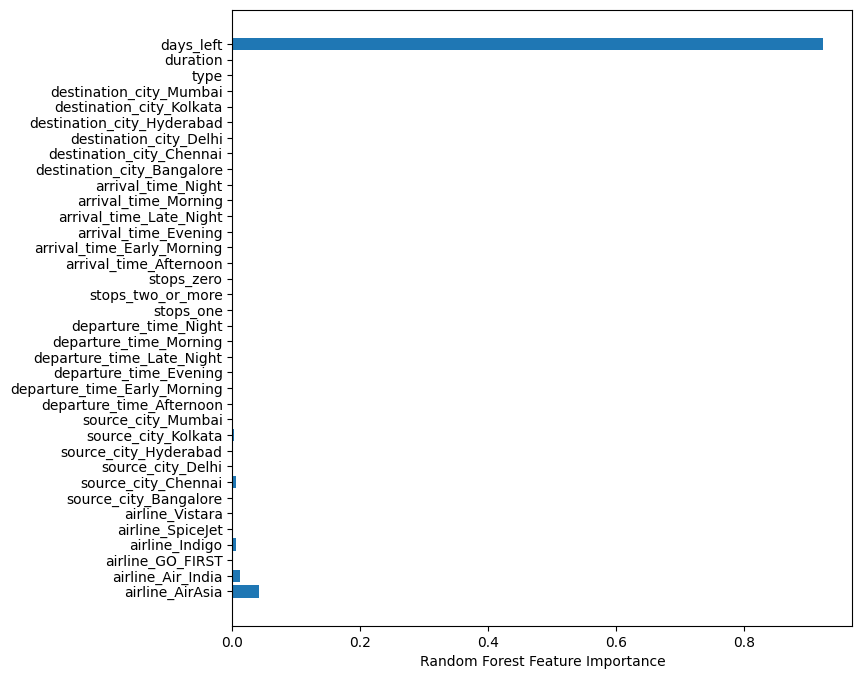

In [542]:
plt.figure(figsize=(8,8))
plt.barh(X_train_final.columns, rfc.feature_importances_)
plt.xlabel("Random Forest Feature Importance")

Insight pada feature importances:

Kolom days_left memiliki pengaruh paling besar di antara semua fitur, menjadi fitur yang paling dominan dalam membuat prediksi.

##  Model Saving



In [543]:
with open("model.pkl", "wb") as f:
    pickle.dump(random, f)

##  Kesimpulan

- Dataset terdiri dari 300,153 entri dan 11 kolom, termasuk atribut seperti airline, flight, source_city, departure_time, stops, arrival_time, destination_city, type, duration, days_left, dan price. Kemudian dilakukan pengambilan sample sebanyak 50.000

- Tidak ada missing value dan data duplicate pada setiap kolom dataset.

- Setelah itu dilakukan pemisahan dataset pada data sampel menjadi data train sebanyak 40,000 entri dan data test sebanyak 10,000 entri.

- Kemudian pada data train akan dipilih bebera kolom sebagai fitur. Pemilihan fitur menggunakan uji Pearson, Kendall, Cardinality dan Multicolinear. setelah pengujian tersebut kolom yang terpilih adalah airline, source_city, departure_time, stops, arrival_time, destination_city, type, duration, days_left

- Beirkutnya adalah proses machine learning dengan menguji fitur dengan target menggunakan model KNeighborsRegressor, SVR, DecisionTreeRegressor, RandomForestRegressor dan GradientBoostingRegressor. Hasil dari pengujian menunjukan bahwa kolom RandomForestRegressor memiliki r2 score terbaik dibanding yang lain. Maka RandomForestRegressor terpilih menjadi model untuk memprediksi harga tiket pesawat.

- Model RandomForestRegressor memberikan kinerja yang baik dalam memprediksi harga tiket pesawat, dengan hasil MAE, MSE, RMSE, MAPE, dan R2 yang cukup baik.

- Kolom days_left memiliki pengaruh paling besar di antara semua fitur, menjadi fitur yang paling dominan dalam membuat prediksi.






---

## Conceptual Problems


1. Jelaskan latar belakang adanya bagging dan cara kerja bagging !

    Bagging adalah kependekan dari Bootstrap AGGgregating. Bagging mendapatkan namanya karena menggabungkan Bootstrapping dan Agregasi untuk membentuk satu model ansambel. Bootstrap adalah pengambilan sampel dengan penggantian. Dalam bagging, beberapa model dilatih secara independen pada subset data pelatihan yang berbeda, sering kali diperoleh melalui bootstrapping. Prediksi dari masing-masing model kemudian digabungkan, biasanya dengan membuat rata-rata untuk tugas regresi atau berdasarkan suara mayoritas untuk tugas klasifikasi. Random Forest adalah contoh algoritma bagging yang populer. Random Forest merupakan model ensembel dimana masing-masing model independen merupakan Decision Tree.

2. Jelaskan perbedaan cara kerja algoritma Random Forest dengan algoritma boosting yang Anda pilih !

    Keduanya merupakan model ansambel, dan keduanya memanfaatkan pohon keputusan sebagai base estimator. Perbedaannya terdapat pada ensembling method.

    Random Forest menggunakan ensembling dengan cara yang lebih intuitif, pada dasarnya menggunakan prinsip “wisdom of the crowds”. RF akan membangun N pohon keputusan dan kemudian membuat rata-rata prediksi secara demokratis. Setiap pohon dihitung untuk satu suara. Setiap pohon menggunakan sampel yang berbeda dari data asli sehingga menimbulkan pengacakan.

    Gradien Boosting akan menggunakan pendekatan yang berbeda. Dimulai dengan pohon yang tidak terlalu dalam dan akan memodelkan target awal. Kemudian ia mengambil kesalahan dari prediksi putaran pertama, dan meneruskan kesalahan tersebut sebagai target baru ke pohon kedua. Pohon kedua akan memodelkan kesalahan dari pohon pertama, mencatat kesalahan baru dan meneruskannya sebagai target ke pohon ketiga. Dan seterusnya. Pada dasarnya ini berfokus pada kesalahan pemodelan dari pohon sebelumnya.


3. Jelaskan apa yang dimaksud dengan Cross Validation !

    Cross Validation adalah teknik evaluasi model yang melibatkan pembagian dataset menjadi subset yang saling tumpang tindih untuk mengukur kinerja model. Dalam Cross Validation, dataset dibagi menjadi beberapa bagian atau lipatan (folds), dan model dievaluasi secara berulang menggunakan subset tersebut. Pada setiap iterasi, satu lipatan dijadikan data validasi, sementara yang lain digunakan sebagai data pelatihan. Proses ini membantu memitigasi variabilitas hasil evaluasi dan memastikan model dinilai dengan sebaik-baiknya dengan memanfaatkan seluruh dataset yang tersedia.